In [1]:
# Import libraries that will be needed for the lab
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime
import seaborn as sns
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

In [276]:
#!pip install tensorflow_gpu==2.10.0

In [277]:
# Download the dataset
dataset = pd.read_csv('testw.csv')
raw_data = dataset.values
dataset=dataset.drop('Index', axis=1)
dataset.head()

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694791e+09,PA,256.0,24061.0,375.0,1.732513
1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,6.0,1.694791e+09,4.148861e+09,A,980.0,56192.0,1500.0,1.726963
2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,6.0,1.694793e+09,4.148861e+09,PA,980.0,13256.0,262.0,1.732513
3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,40.0,1.542778
4,1.518611e+09,12238,0,0,2,0,137.0,137.0,17.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,78.0,1.153846


In [278]:

freq_imputer = SimpleImputer(strategy='most_frequent')

protocol = dataset.drop('Proto', axis=1)


dataset.Proto = freq_imputer.fit_transform(protocol)

# Calculate the mode value of column 'B'
mode_value = dataset['TCP_Flag'].mode()[0]

# Fill missing values in column 'B' with the mode value
dataset['TCP_Flag'] = dataset['TCP_Flag'].fillna(mode_value)
#Drop a row where the source port and destination ports are not known

dataset = dataset.dropna(subset=["Dest_Port"])


In [279]:
dataset.Ack_Num = dataset.Ack_Num.fillna(0)#zero_imputer.fit_transform(ack_num)
dataset.Seq_Num = dataset.Seq_Num.fillna(0)#zero_imputer.fit_transform(seq_num)

In [280]:
dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']] = dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].fillna(dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].median())

In [281]:
ord_encoder = OrdinalEncoder()
dataset['TCP_Flag'] = ord_encoder.fit_transform(dataset[['TCP_Flag']])

In [2]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [3]:
train_data_dir='ImageDataset2/Training'
test_data_dir='ImageDataset2/Testing'
directory='ImageDataset'
IMAGE_SIZE=(64, 64)
BATCH_SIZE =100
# Import dataset
train_dataset_cnn = train_datagen.flow_from_directory(train_data_dir, target_size=IMAGE_SIZE, #color_mode='grayscale', seed=42,
    batch_size=BATCH_SIZE, subset='training', shuffle=True,  class_mode='input')
#train_dataset_cnn = tf.keras.utils.image_dataset_from_directory('ImageDataset/train', labels=None, color_mode='rgb',
 #                   image_size=(128, 128), batch_size=32, shuffle=True, seed=42, 
  #                  validation_split=0.2,subset='training')

# Import dataset
#
val_dataset_cnn = train_datagen.flow_from_directory(train_data_dir, target_size=IMAGE_SIZE, #color_mode='grayscale', seed=42,
    batch_size=BATCH_SIZE, subset='validation', shuffle=True,  class_mode='input')
#val_dataset_cnn = dataset_augmentation.flow_from_directory(train_data_dir, target_size=image_size, color_mode='grayscale',
#    batch_size=batch_size, subset='validation', shuffle=True, seed=42, class_mode='input')

Found 14286 images belonging to 2 classes.
Found 3571 images belonging to 2 classes.


In [300]:
train_dataset_cnn

0

In [285]:
#normalization_layer = layers.Rescaling(1./255)

In [302]:
#test_dataset_cnn = tf.keras.utils.image_dataset_from_directory('ImageDataset/test', labels=None, color_mode='rgb', 
 #                                                               batch_size=32, image_size=(128, 128), shuffle=True, seed=42)

#test_dataset_cnn = train_datagen.flow_from_directory(test_data_dir, target_size=IMAGE_SIZE, #color_mode='grayscale', seed=42,
#    batch_size=BATCH_SIZE, subset='testing', shuffle=True,  class_mode='input')

In [287]:
# Configure the dataset for performance
#train_dataset_cnn = train_dataset_cnn.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#val_dataset_cnn = val_dataset_cnn.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_dataset_cnn = test_dataset_cnn.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [4]:
train_examples_num = train_dataset_cnn.samples   #len(os.listdir(train_data_dir+'/train'))
#test_examples_num  = test_dataset_cnn.samples   #len(os.listdir(test_data_dir+'/test'))
val_examples_num   = val_dataset_cnn.samples

In [289]:
#def change_inputs(images):
#    x = tf.image.resize(normalization_layer(images),[128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#    return x, x

In [290]:
#train_dataset_cnn =  train_dataset_cnn.map(lambda x: normalization_layer(x))

#train_dataset_cnn =  train_dataset_cnn.map(change_inputs)

#train_dataset_cnn = np.reshape(train_dataset_cnn, (len(train_dataset_cnn), 128, 128, 1))
#test_dataset_cnn = np.reshape(test_dataset_cnn, (len(test_dataset_cnn),  28, 28, 1))

# Loading the dataset in cache memory
#train_dataset_cnn =  train_dataset_cnn.cache()
#test_dataset_cnn  =  test_dataset_cnn.cache()

In [5]:
train_dataset_cnn.samples

14286

In [6]:
image_batch, _ = next(iter(train_dataset_cnn))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 0.9921569


In [268]:
"""folder_path = 'ImageDataset2/Training/'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:    
            im = Image.open(file_path)
        except:
            print(f'image {file_path} was removed')
            os.remove(file_path)
   
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])"""

'folder_path = \'ImageDataset2/Training/\'\nextensions = []\nfor fldr in os.listdir(folder_path):\n    sub_folder_path = os.path.join(folder_path, fldr)\n    for filee in os.listdir(sub_folder_path):\n        \n        file_path = os.path.join(sub_folder_path, filee)\n        print(\'** Path: {}  **\'.format(file_path), end="\r", flush=True)\n        try:    \n            im = Image.open(file_path)\n        except:\n            print(f\'image {file_path} was removed\')\n            os.remove(file_path)\n   \n        rgb_im = im.convert(\'RGB\')\n        if filee.split(\'.\')[1] not in extensions:\n            extensions.append(filee.split(\'.\')[1])'

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

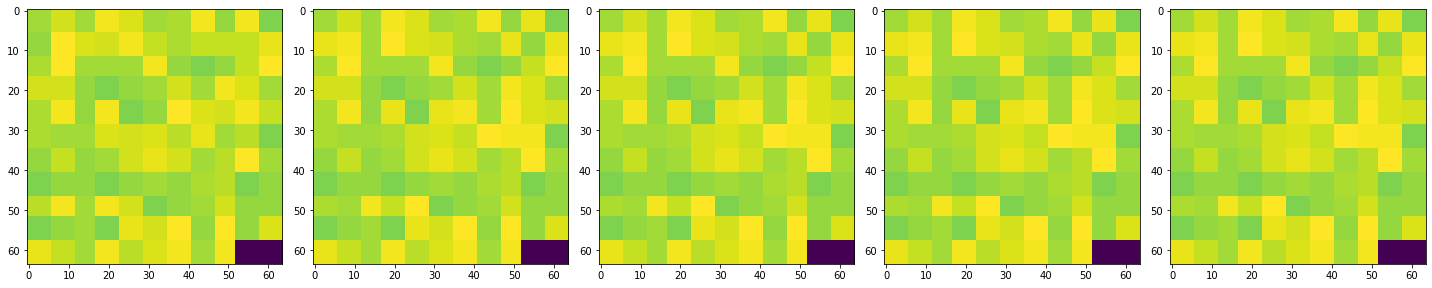

In [8]:
augmented_images = [train_dataset_cnn[i][0][0] for i in range(5)]
plotImages(augmented_images)

In [145]:
"""input_shape=(64, 64, 3)
#class ConvAutoencoder(Model):
#    def __init__(self):
#        super(ConvAutoencoder, self).__init__()
cnnencoder =  tf.keras.Sequential([
              tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu,
                                               input_shape=input_shape),
              tf.keras.layers.MaxPooling2D((2, 2), strides=2),
              tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
              tf.keras.layers.MaxPooling2D((2, 2), strides=2),
              tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
              tf.keras.layers.MaxPooling2D((2, 2), strides=2)
                        #tf.keras.layers.Flatten(),
                        #tf.keras.layers.Dense(128, activation=tf.nn.relu)
                        #tf.keras.layers.Dense(10, activation=tf.nn.relu)
              ])

cnndecoder = tf.keras.Sequential([
             #tf.keras.layers.Dense(10, activation=tf.nn.relu),
             #tf.keras.layers.Dense(128, activation=tf.nn.relu),
            #tf.keras.layers.Flatten(),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(3, (3,3), padding='same', activation=tf.nn.sigmoid),
            tf.keras.layers.UpSampling2D((2, 2))
            ])
        
  #  def call(self, x):
   #     encoded = self.cnnencoder(x)
        
    #    decoded = self.cnndecoder(encoded)
     #   return decoded

conv_autoencoder = tf.keras.models.Sequential([
    cnnencoder,
    cnndecoder
])"""

In [146]:
#conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [147]:
#conv_autoencoder.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 8, 8, 32)          95840     
                                                                 
 sequential_16 (Sequential)  (None, 64, 64, 3)         29475     
                                                                 
Total params: 125,315
Trainable params: 125,315
Non-trainable params: 0
_________________________________________________________________


In [148]:
#logdir = os.path.join("ConvAElogs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)


In [149]:
#Strop training when overfitting is detected
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
#                                                  patience=5, 
#                                                  min_delta=0.001, 
#                                                  mode='auto', 
#                                                  verbose=2, 
#                                                  baseline=None, 
#                                                  restore_best_weights=True)


In [150]:
#cnn_training = conv_autoencoder.fit(train_dataset_cnn, 
#                                    epochs=200, 
#                                    steps_per_epoch=int(np.ceil(train_examples_num / float(BATCH_SIZE))), 
#                                    validation_data= val_dataset_cnn,
#                                    validation_steps=int(np.ceil(val_examples_num / float(BATCH_SIZE))),
#                                    shuffle=True, 
#                                    batch_size=128, 
#                                    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/200
143/143 [==============================] - 97s 675ms/step - loss: 0.4774 - accuracy: 0.7469 - val_loss: 0.4578 - val_accuracy: 0.8123
Epoch 2/200
143/143 [==============================] - 113s 789ms/step - loss: 0.4552 - accuracy: 0.8631 - val_loss: 0.4539 - val_accuracy: 0.8912
Epoch 3/200
143/143 [==============================] - 113s 791ms/step - loss: 0.4535 - accuracy: 0.8995 - val_loss: 0.4530 - val_accuracy: 0.9064
Epoch 4/200
143/143 [==============================] - 113s 791ms/step - loss: 0.4528 - accuracy: 0.9094 - val_loss: 0.4530 - val_accuracy: 0.9126
Epoch 5/200
143/143 [==============================] - 112s 787ms/step - loss: 0.4526 - accuracy: 0.9146 - val_loss: 0.4526 - val_accuracy: 0.9175
Epoch 6/200
143/143 [==============================] - 112s 786ms/step - loss: 0.4524 - accuracy: 0.9182 - val_loss: 0.4523 - val_accuracy: 0.9232
Epoch 7/200
143/143 [==============================] - 414s 3s/step - loss: 0.4522 - accuracy: 0.9231 - val_loss: 0.452

In [195]:
#tf.saved_model.save(conv_autoencoder, 'tensormodel/convoAE')
#conv_autoencoder.save('CNNAE.h5')
#new_model = tf.keras.models.load_model('saved_model/my_model')

INFO:tensorflow:Assets written to: tensormodel/newConvoAE\assets


INFO:tensorflow:Assets written to: tensormodel/newConvoAE\assets


In [211]:
file = open('CNNAE_loss_acc_records.txt', 'w')
file.write(str(cnn_training.history))
file.close()

In [13]:
# Loading the model
convolutionAE = tf.keras.models.load_model('CNNAE.h5')
#convolutionAE = tf.keras.models.load_model('tensormodel/newConvoAE')

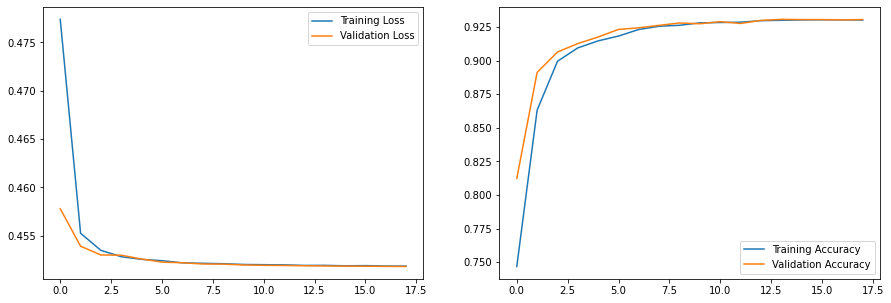

In [223]:


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_training.history['loss'], label="Training Loss")
plt.plot(cnn_training.history["val_loss"], label="Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(cnn_training.history["accuracy"], label="Training Accuracy")
plt.plot(cnn_training.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

plt.savefig('CNNAE Training_Loss_Accuracy.png')

plt.show()


In [14]:
reconstructed = convolutionAE.predict(train_dataset_cnn)
#decoded_imgs = autoencoder.predict(x_test)

143/143 [==============================] - 102s 712ms/step


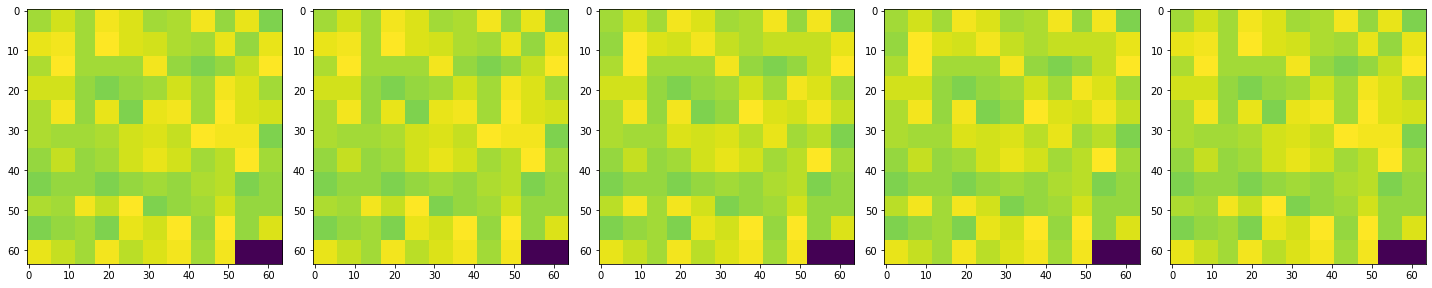

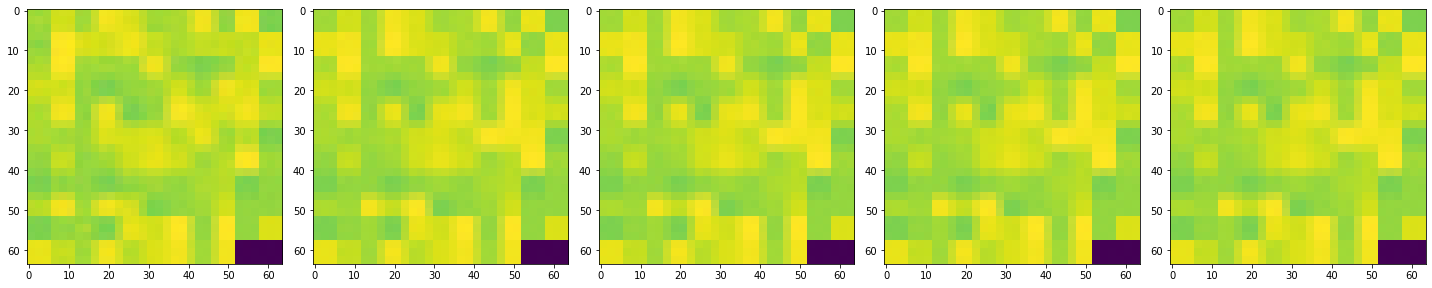

In [272]:
augmented_images = [train_dataset_cnn[i][0][0] for i in range(5)]
plotImages(augmented_images)

rec_images = [reconstructed[i] for i in range(5)]
plotImages(rec_images)

In [406]:
type(train_dataset_cnn)

keras.preprocessing.image.DirectoryIterator

In [402]:
total_loss = 0
num_batches = 0

for i in range(len(train_dataset_cnn)):
    real_samples, _ = train_dataset_cnn[i]
    batch_loss = tf.keras.losses.binary_crossentropy(real_samples, reconstructed)
    total_loss += batch_loss.numpy().mean()
    num_batches += 1


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100,64,64,3] vs. [14286,64,64,3] [Op:Mul]

In [386]:
train_loss = tf.keras.losses.binary_crossentropy(image_batch, reconstructed, from_logits=True)

# Plot the histogram using seaborn
plt.subplots(dpi=800)

dist_sns = sns.distplot(train_loss[None,:], color="b")

plt.xlabel("Train Loss")
plt.ylabel("Number of Samples")
plt.savefig("sns_distri.png")

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100,64,64,3] vs. [14286,64,64,3] [Op:Mul]

In [ ]:
#threshold = np.mean(train_loss) + np.std(train_loss)
# Compute the median and MAD of the reconstruction error
b = 1.4826
median = np.median(train_loss)
mad = b * np.median(np.abs(train_loss - median))

# Set the threshold based on the median and MAD
k = 3
threshold = median + k * mad

print("Threshold: ", threshold) 

In [ ]:
reconstructed_test = convolutionAE.predict(test_data_norm)
train_loss = tf.keras.losses.binary_crossentropy(reconstructions, test_data_norm)

a=np.array(train_loss[None,:] )

anomaly = a[a >= threshold]
normal =  a[a < threshold]

plt.hist(normal, color='g')
plt.hist(anomaly, color='orange')
plt.xlabel("Training loss")
plt.ylabel("No of Samples")

plt.axvline(threshold, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Anomaly Sample.png")
plt.show()

In [2]:
autoencoder = tf.saved_model.load('tensormodel/Sparse_Autoencoder_Model_RELU')

In [ ]:
autoencoder.